# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters （可以自己调整的）

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128 
NUM_EPOCHS = 30 # Number of Epoches
EVAL_INTERVAL=1 
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-3
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

### FocalLoss

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        # 计算交叉熵损失
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # 计算 softmax
        probs = torch.exp(-ce_loss)
        
        # 计算 Focal Loss
        focal_loss = (self.alpha * (1 - probs) ** self.gamma) * ce_loss

        # 计算平均损失
        return focal_loss.mean()

Define different loss functions：

In [9]:
##################### Write your answer here ##################
criterion_L1 = nn.L1Loss()
criterion_CE = nn.CrossEntropyLoss()
criterion_F_oneHalf = FocalLoss(alpha=0.25, gamma=0.5)
criterion_F_2 = FocalLoss(alpha=0.25, gamma=2)
###############################################################

### Set the loss function as L1 loss:

In [10]:
def train_batch_L1(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion_L1(output,target)
    ###############################################################

    return output, loss

In [11]:

def test_batch_L1(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion_L1(output,target)
    ###############################################################

    return output, loss

#### Model Training

In [12]:
training_loss_L1 = []
training_acc_L1 = []
testing_loss_L1 = []
testing_acc_L1 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):
        model = model.to(device)
        image = image.to(device)
        target_initial = target
        target_initial = target_initial.to(device)
        target = F.one_hot(target,num_classes=10)
        target = target.to(device)

        # train model
        outputs, loss = train_batch_L1(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target_initial.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set) #training loss
    epoch_acc = running_cls_corrects.double() / len(train_set) #training accuracy

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_L1.append(epoch_loss)
    training_acc_L1.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target_initial = target
            target_initial = target_initial.to(device)
            target = F.one_hot(target,num_classes=10)
            target = target.to(device)

            # test model
            outputs, loss = test_batch_L1(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target_initial.data)

        val_loss = val_loss / len(test_set) #testing loss
        val_acc = val_corrects.double() / len(test_set) #testing accuracy
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_L1.append(val_loss)
        testing_acc_L1.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0009 Acc: 0.1120
Begin test......
Test Loss: 0.0009 Acc: 0.1249
Epoch: 2/30 Train Loss: 0.0008 Acc: 0.1163
Begin test......
Test Loss: 0.0008 Acc: 0.1207
Epoch: 3/30 Train Loss: 0.0008 Acc: 0.1174
Begin test......
Test Loss: 0.0008 Acc: 0.1158
Epoch: 4/30 Train Loss: 0.0008 Acc: 0.1125
Begin test......
Test Loss: 0.0008 Acc: 0.1108
Epoch: 5/30 Train Loss: 0.0008 Acc: 0.1083
Begin test......
Test Loss: 0.0008 Acc: 0.1068
Epoch: 6/30 Train Loss: 0.0008 Acc: 0.1075
Begin test......
Test Loss: 0.0008 Acc: 0.1058
Epoch: 7/30 Train Loss: 0.0008 Acc: 0.1059
Begin test......
Test Loss: 0.0008 Acc: 0.1061
Epoch: 8/30 Train Loss: 0.0008 Acc: 0.1050
Begin test......
Test Loss: 0.0008 Acc: 0.1087
Epoch: 9/30 Train Loss: 0.0008 Acc: 0.1061
Begin test......
Test Loss: 0.0008 Acc: 0.1057
Epoch: 10/30 Train Loss: 0.0008 Acc: 0.1040
Begin test......
Test Loss: 0.0008 Acc: 0.1069
Epoch: 11/30 Train Loss: 0.0008 Acc: 0.1070
Begin test......
Test Loss: 0.0008 Acc: 0.1059
Epoch: 1

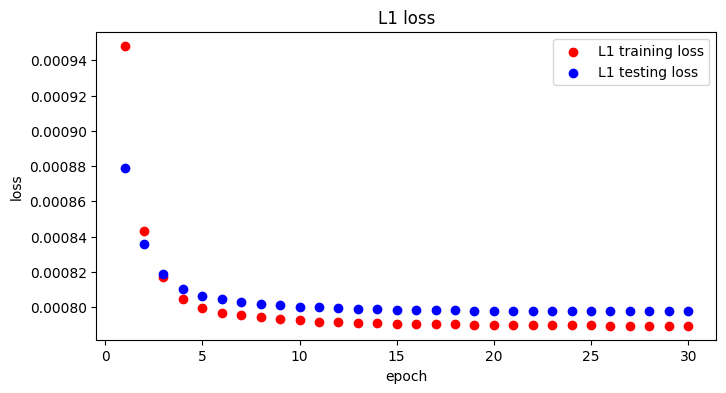

In [13]:
import matplotlib.pyplot as plt
import numpy as np

numbers_range = range(1, NUM_EPOCHS+1)
numbers_list = list(numbers_range)

plt.figure(figsize=(8, 4)) 
plt.scatter(numbers_range,  # 横坐标
            training_loss_L1,  # 纵坐标
            c='red',  # 点的颜色
            label='L1 training loss')  # 标签 即为点代表的意思
plt.scatter(numbers_range,  # 横坐标
            testing_loss_L1,  # 纵坐标
            c='blue',  # 点的颜色
            label='L1 testing loss')  # 标签 即为点代表的意思
plt.title('L1 loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()  # 显示图例
plt.show()

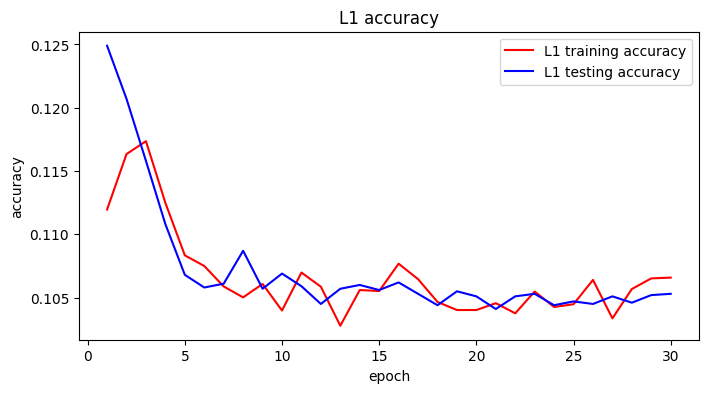

In [14]:
plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            training_acc_L1,  # 纵坐标
            c='red', linestyle='-',# 点的颜色
            label='L1 training accuracy')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            testing_acc_L1,  # 纵坐标
            c='blue', linestyle='-', # 点的颜色
            label='L1 testing accuracy')  # 标签 即为点代表的意思
plt.title('L1 accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()  # 显示图例
plt.show()

In [16]:
np.savetxt('L1_tr_loss.txt',training_loss_L1)
np.savetxt('L1_te_loss.txt', testing_loss_L1)
np.savetxt('L1_tr_acc.txt', training_acc_L1)
np.savetxt('L1_te_acc.txt', testing_acc_L1)

### Set the loss function as Cross Entropy loss:

In [10]:
def train_batch_CE(model, image, target):
    output_CE = model(image)
    loss_CE = criterion_CE(output_CE,target)
    
    return output_CE, loss_CE

In [11]:
def test_batch_CE(model, image, target):
    
    output_CE = model(image)
    loss_CE = criterion_CE(output_CE,target)
   
    return output_CE, loss_CE

In [12]:
training_loss_CE = []
training_acc_CE = []
testing_loss_CE = []
testing_acc_CE = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):
        model = model.to(device)
        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch_CE(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_CE.append(epoch_loss)
    training_acc_CE.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch_CE(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_CE.append(val_loss)
        testing_acc_CE.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0177 Acc: 0.1468
Begin test......
Test Loss: 0.0170 Acc: 0.2364
Epoch: 2/30 Train Loss: 0.0161 Acc: 0.2513
Begin test......
Test Loss: 0.0154 Acc: 0.2854
Epoch: 3/30 Train Loss: 0.0153 Acc: 0.2863
Begin test......
Test Loss: 0.0147 Acc: 0.3262
Epoch: 4/30 Train Loss: 0.0147 Acc: 0.3146
Begin test......
Test Loss: 0.0140 Acc: 0.3632
Epoch: 5/30 Train Loss: 0.0142 Acc: 0.3331
Begin test......
Test Loss: 0.0136 Acc: 0.3787
Epoch: 6/30 Train Loss: 0.0139 Acc: 0.3494
Begin test......
Test Loss: 0.0133 Acc: 0.3934
Epoch: 7/30 Train Loss: 0.0136 Acc: 0.3657
Begin test......
Test Loss: 0.0130 Acc: 0.4033
Epoch: 8/30 Train Loss: 0.0134 Acc: 0.3702
Begin test......
Test Loss: 0.0128 Acc: 0.4164
Epoch: 9/30 Train Loss: 0.0132 Acc: 0.3812
Begin test......
Test Loss: 0.0125 Acc: 0.4306
Epoch: 10/30 Train Loss: 0.0130 Acc: 0.3955
Begin test......
Test Loss: 0.0124 Acc: 0.4333
Epoch: 11/30 Train Loss: 0.0129 Acc: 0.4013
Begin test......
Test Loss: 0.0122 Acc: 0.4404
Epoch: 1

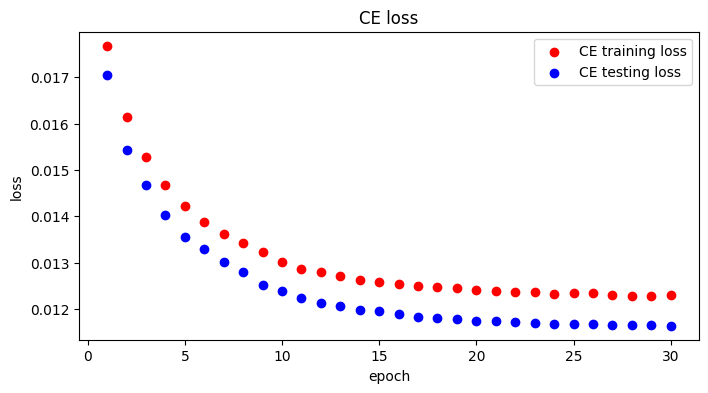

In [13]:
import matplotlib.pyplot as plt
import numpy as np

numbers_range = range(1, NUM_EPOCHS+1)
numbers_list = list(numbers_range)

plt.figure(figsize=(8, 4)) 
plt.scatter(numbers_range,  # 横坐标
            training_loss_CE,  # 纵坐标
            c='red',  # 点的颜色
            label='CE training loss')  # 标签 即为点代表的意思
plt.scatter(numbers_range,  # 横坐标
            testing_loss_CE,  # 纵坐标
            c='blue',  # 点的颜色
            label='CE testing loss')  # 标签 即为点代表的意思
plt.title('CE loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()  # 显示图例
plt.show()

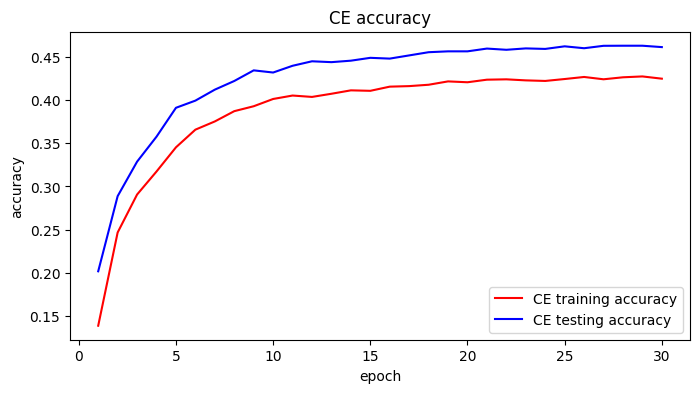

In [14]:
plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            training_acc_CE,  # 纵坐标
            c='red', linestyle='-',# 点的颜色
            label='CE training accuracy')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            testing_acc_CE,  # 纵坐标
            c='blue', linestyle='-', # 点的颜色
            label='CE testing accuracy')  # 标签 即为点代表的意思
plt.title('CE accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()  # 显示图例
plt.show()

In [14]:
np.savetxt('CE_tr_loss.txt',training_loss_CE)
np.savetxt('CE_te_loss.txt', testing_loss_CE)
np.savetxt('CE_tr_acc.txt', training_acc_CE)
np.savetxt('CE_te_acc.txt', testing_acc_CE)

### Set the loss function as focal loss(alpha=0.5):

In [10]:
def train_batch_oH(model, image, target):
    output = model(image)
    loss = criterion_F_oneHalf(output,target)
    
    return output, loss

In [11]:
def test_batch_oH(model, image, target):
    
    output = model(image)
    loss = criterion_F_oneHalf(output,target)
   
    return output, loss

In [12]:
training_loss_F_oneHalf = []
training_acc_F_oneHalf = []
testing_loss_F_oneHalf = []
testing_acc_F_oneHalf = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):
        model = model.to(device)
        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch_oH(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_F_oneHalf.append(epoch_loss)
    training_acc_F_oneHalf.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch_oH(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_F_oneHalf.append(val_loss)
        testing_acc_F_oneHalf.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0043 Acc: 0.1225
Begin test......
Test Loss: 0.0043 Acc: 0.1227
Epoch: 2/30 Train Loss: 0.0043 Acc: 0.1316
Begin test......
Test Loss: 0.0043 Acc: 0.1440
Epoch: 3/30 Train Loss: 0.0042 Acc: 0.1592
Begin test......
Test Loss: 0.0042 Acc: 0.1837
Epoch: 4/30 Train Loss: 0.0041 Acc: 0.1936
Begin test......
Test Loss: 0.0041 Acc: 0.2412
Epoch: 5/30 Train Loss: 0.0040 Acc: 0.2353
Begin test......
Test Loss: 0.0039 Acc: 0.2626
Epoch: 6/30 Train Loss: 0.0039 Acc: 0.2477
Begin test......
Test Loss: 0.0038 Acc: 0.2782
Epoch: 7/30 Train Loss: 0.0038 Acc: 0.2578
Begin test......
Test Loss: 0.0037 Acc: 0.2864
Epoch: 8/30 Train Loss: 0.0038 Acc: 0.2667
Begin test......
Test Loss: 0.0037 Acc: 0.2967
Epoch: 9/30 Train Loss: 0.0037 Acc: 0.2750
Begin test......
Test Loss: 0.0036 Acc: 0.3062
Epoch: 10/30 Train Loss: 0.0037 Acc: 0.2808
Begin test......
Test Loss: 0.0036 Acc: 0.3116
Epoch: 11/30 Train Loss: 0.0036 Acc: 0.2878
Begin test......
Test Loss: 0.0036 Acc: 0.3136
Epoch: 1

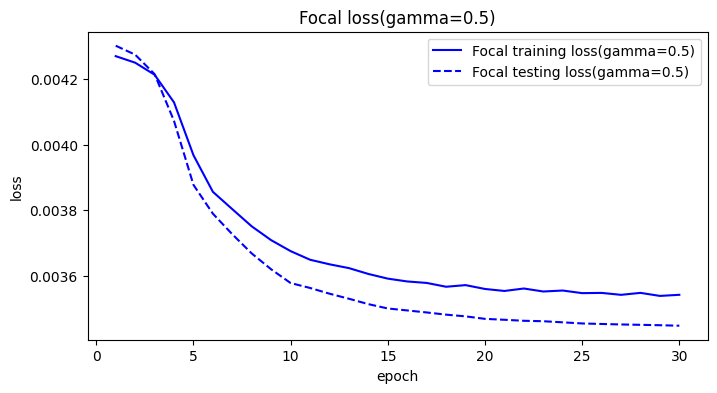

In [36]:
import matplotlib.pyplot as plt
import numpy as np

numbers_range = range(1, NUM_EPOCHS+1)
numbers_list = list(numbers_range)

plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            F_oH_tr_loss,  # 纵坐标
            c='blue',linestyle='-',  # 点的颜色
            label='Focal training loss(gamma=0.5)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            F_oH_te_loss,  # 纵坐标
            c='blue',linestyle='--', # 点的颜色
            label='Focal testing loss(gamma=0.5)')  # 标签 即为点代表的意思
plt.title('Focal loss(gamma=0.5)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()  # 显示图例
plt.show()

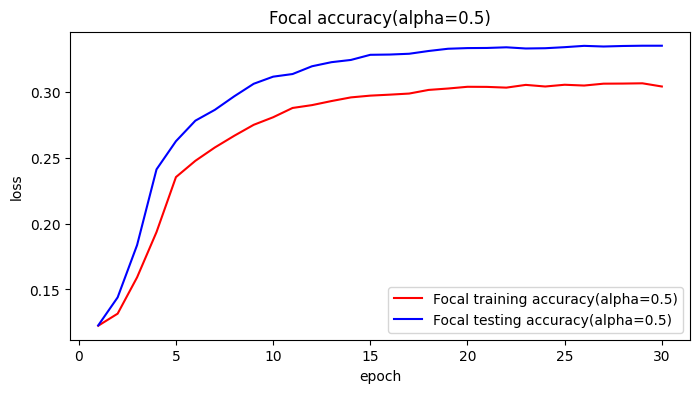

In [14]:
plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            training_acc_F_oneHalf,  # 纵坐标
            c='red', linestyle='-',# 点的颜色
            label='Focal training accuracy(alpha=0.5)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            testing_acc_F_oneHalf,  # 纵坐标
            c='blue', linestyle='-', # 点的颜色
            label='Focal testing accuracy(alpha=0.5)')  # 标签 即为点代表的意思
plt.title('Focal accuracy(alpha=0.5)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()  # 显示图例
plt.show()

In [16]:
np.savetxt('F0.5_tr_loss.txt',training_loss_F_oneHalf)
np.savetxt('F0.5_te_loss.txt', testing_loss_F_oneHalf)
np.savetxt('F0.5_tr_acc.txt', training_acc_F_oneHalf)
np.savetxt('F0.5_te_acc.txt', testing_acc_F_oneHalf)

### Set the loss function as focal loss(alpha=2):

In [10]:
def train_batch(model, image, target):
    output = model(image)
    loss = criterion_F_2(output,target)
    
    return output, loss
def test_batch(model, image, target):
    
    output = model(image)
    loss = criterion_F_2(output,target)
   
    return output, loss

In [11]:
training_loss_F_2 = []
training_acc_F_2 = []
testing_loss_F_2 = []
testing_acc_F_2 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):
        model = model.to(device)
        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss_F_2.append(epoch_loss)
    training_acc_F_2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss_F_2.append(val_loss)
        testing_acc_F_2.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0037 Acc: 0.0930
Begin test......
Test Loss: 0.0037 Acc: 0.0993
Epoch: 2/30 Train Loss: 0.0037 Acc: 0.1053
Begin test......
Test Loss: 0.0037 Acc: 0.1139
Epoch: 3/30 Train Loss: 0.0036 Acc: 0.1221
Begin test......
Test Loss: 0.0037 Acc: 0.1291
Epoch: 4/30 Train Loss: 0.0036 Acc: 0.1425
Begin test......
Test Loss: 0.0036 Acc: 0.1574
Epoch: 5/30 Train Loss: 0.0036 Acc: 0.1505
Begin test......
Test Loss: 0.0035 Acc: 0.1629
Epoch: 6/30 Train Loss: 0.0035 Acc: 0.1573
Begin test......
Test Loss: 0.0035 Acc: 0.1700
Epoch: 7/30 Train Loss: 0.0034 Acc: 0.1674
Begin test......
Test Loss: 0.0034 Acc: 0.1794
Epoch: 8/30 Train Loss: 0.0034 Acc: 0.1774
Begin test......
Test Loss: 0.0033 Acc: 0.2029
Epoch: 9/30 Train Loss: 0.0033 Acc: 0.2037
Begin test......
Test Loss: 0.0032 Acc: 0.2398
Epoch: 10/30 Train Loss: 0.0032 Acc: 0.2355
Begin test......
Test Loss: 0.0032 Acc: 0.2587
Epoch: 11/30 Train Loss: 0.0032 Acc: 0.2446
Begin test......
Test Loss: 0.0031 Acc: 0.2671
Epoch: 1

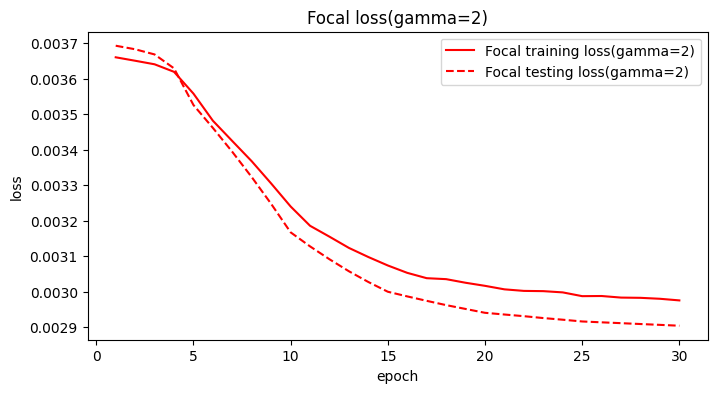

In [37]:
numbers_range = range(1, NUM_EPOCHS+1)
numbers_list = list(numbers_range)

plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            training_loss_F_2, linestyle='-', # 纵坐标
            c='red',  # 点的颜色
            label='Focal training loss(gamma=2)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            testing_loss_F_2,  # 纵坐标
            c='red',linestyle='--',  # 点的颜色
            label='Focal testing loss(gamma=2)')  # 标签 即为点代表的意思
plt.title('Focal loss(gamma=2)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()  # 显示图例
plt.show()

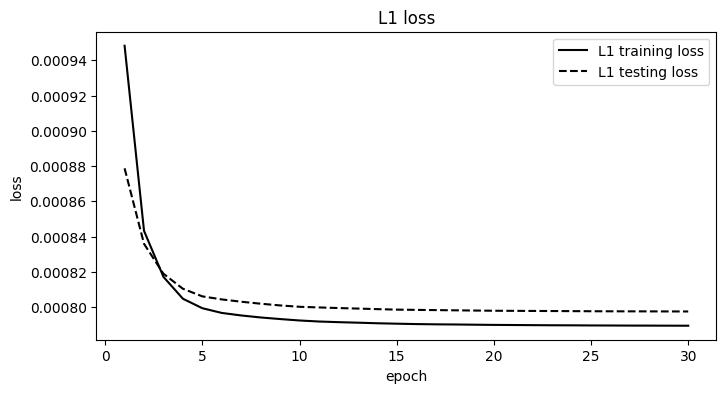

In [38]:
import matplotlib.pyplot as plt
import numpy as np

numbers_range = range(1, NUM_EPOCHS+1)
numbers_list = list(numbers_range)

plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            L1_tr_loss,  # 纵坐标
            c='black',linestyle='-',  # 点的颜色
            label='L1 training loss')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            L1_te_loss,  # 纵坐标
            c='black',linestyle='--', # 点的颜色
            label='L1 testing loss')  # 标签 即为点代表的意思
plt.title('L1 loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()  # 显示图例
plt.show()

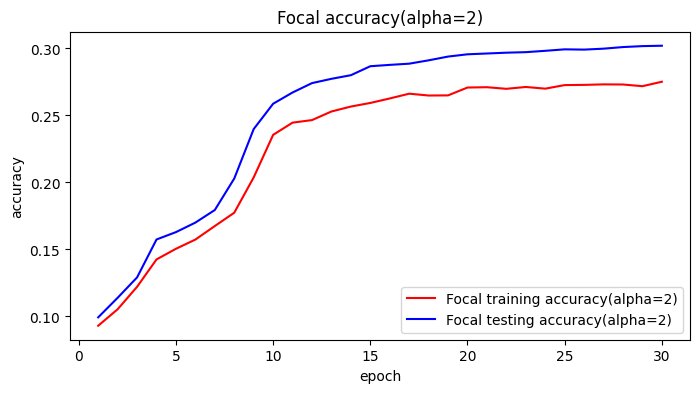

In [13]:
plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            training_acc_F_2,  # 纵坐标
            c='red', linestyle='-',# 点的颜色
            label='Focal training accuracy(alpha=2)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            testing_acc_F_2,  # 纵坐标
            c='blue', linestyle='-', # 点的颜色
            label='Focal testing accuracy(alpha=2)')  # 标签 即为点代表的意思
plt.title('Focal accuracy(alpha=2)')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()  # 显示图例
plt.show()

In [14]:
np.savetxt('F2_tr_loss.txt',training_loss_F_2)
np.savetxt('F2_te_loss.txt', testing_loss_F_2)
np.savetxt('F2_tr_acc.txt', training_acc_F_2)
np.savetxt('F2_te_acc.txt', testing_acc_F_2)

In [17]:
CE_te_acc=np.loadtxt('CE_te_acc.txt')
L1_te_acc=np.loadtxt('L1_te_acc.txt')
F_oH_te_acc=np.loadtxt('F0.5_te_acc.txt')

CE_tr_acc=np.loadtxt('CE_tr_acc.txt')
L1_tr_acc=np.loadtxt('L1_tr_acc.txt')
F_oH_tr_acc=np.loadtxt('F0.5_tr_acc.txt')

CE_te_loss=np.loadtxt('CE_te_loss.txt')
L1_te_loss=np.loadtxt('L1_te_loss.txt')
F_oH_te_loss=np.loadtxt('F0.5_te_loss.txt')

CE_tr_loss=np.loadtxt('CE_tr_loss.txt')
L1_tr_loss=np.loadtxt('L1_tr_loss.txt')
F_oH_tr_loss=np.loadtxt('F0.5_tr_loss.txt')

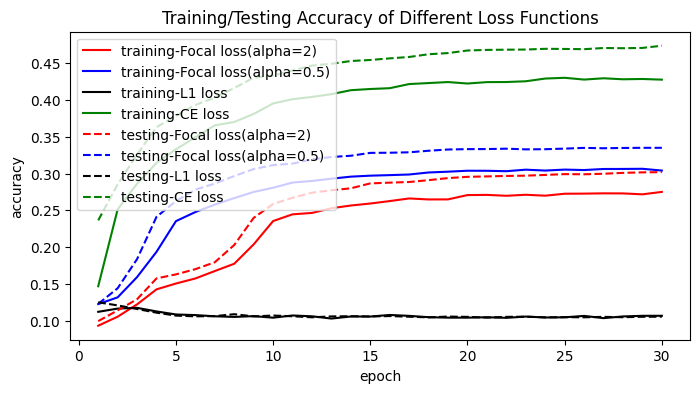

In [29]:
plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            training_acc_F_2,  # 纵坐标
            c='red', linestyle='-',# 点的颜色
            label='training-Focal loss(alpha=2)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            F_oH_tr_acc,  # 纵坐标
            c='blue', linestyle='-', # 点的颜色
            label='training-Focal loss(alpha=0.5)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            L1_tr_acc,  # 纵坐标
            c='black', linestyle='-', # 点的颜色
            label='training-L1 loss')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            CE_tr_acc,  # 纵坐标
            c='green', linestyle='-', # 点的颜色
            label='training-CE loss')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            testing_acc_F_2,  # 纵坐标
            c='red', linestyle='--',# 点的颜色
            label='testing-Focal loss(alpha=2)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            F_oH_te_acc,  # 纵坐标
            c='blue', linestyle='--', # 点的颜色
            label='testing-Focal loss(alpha=0.5)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            L1_te_acc,  # 纵坐标
            c='black', linestyle='--', # 点的颜色
            label='testing-L1 loss')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            CE_te_acc,  # 纵坐标
            c='green', linestyle='--', # 点的颜色
            label='testing-CE loss')  # 标签 即为点代表的意思
plt.title('Training/Testing Accuracy of Different Loss Functions')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()  # 显示图例
plt.show()

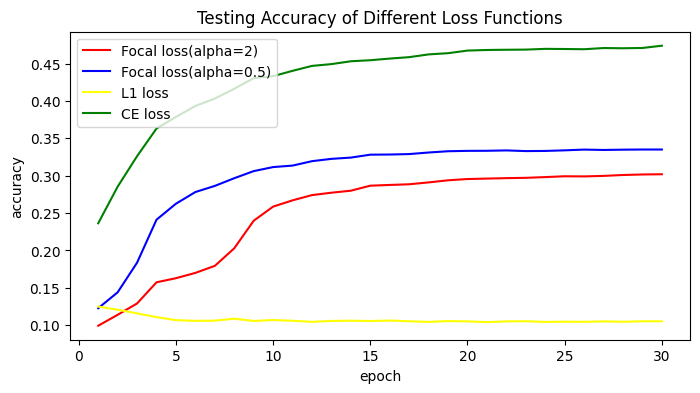

In [23]:
plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            testing_acc_F_2,  # 纵坐标
            c='red', linestyle='-',# 点的颜色
            label='Focal loss(alpha=2)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            F_oH_te_acc,  # 纵坐标
            c='blue', linestyle='-', # 点的颜色
            label='Focal loss(alpha=0.5)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            L1_te_acc,  # 纵坐标
            c='yellow', linestyle='-', # 点的颜色
            label='L1 loss')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            CE_te_acc,  # 纵坐标
            c='green', linestyle='-', # 点的颜色
            label='CE loss')  # 标签 即为点代表的意思
plt.title('Testing Accuracy of Different Loss Functions')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()  # 显示图例
plt.show()

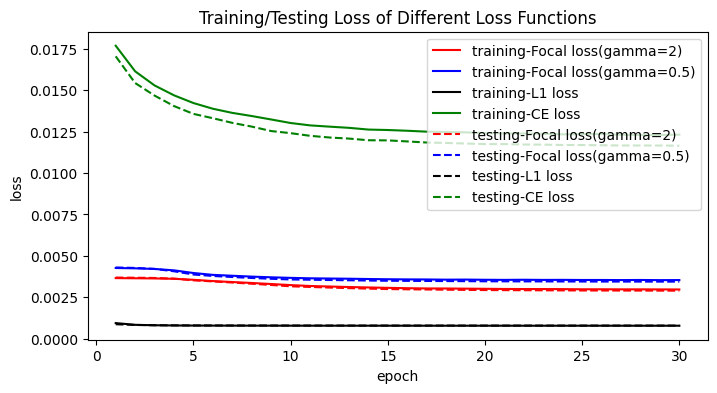

In [31]:
plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            training_loss_F_2,  # 纵坐标
            c='red', linestyle='-',# 点的颜色
            label='training-Focal loss(gamma=2)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            F_oH_tr_loss,  # 纵坐标
            c='blue', linestyle='-', # 点的颜色
            label='training-Focal loss(gamma=0.5)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            L1_tr_loss,  # 纵坐标
            c='black', linestyle='-', # 点的颜色
            label='training-L1 loss')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            CE_tr_loss,  # 纵坐标
            c='green', linestyle='-', # 点的颜色
            label='training-CE loss')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            testing_loss_F_2,  # 纵坐标
            c='red', linestyle='--',# 点的颜色
            label='testing-Focal loss(gamma=2)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            F_oH_te_loss,  # 纵坐标
            c='blue', linestyle='--', # 点的颜色
            label='testing-Focal loss(gamma=0.5)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            L1_te_loss,  # 纵坐标
            c='black', linestyle='--', # 点的颜色
            label='testing-L1 loss')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            CE_te_loss,  # 纵坐标
            c='green', linestyle='--', # 点的颜色
            label='testing-CE loss')  # 标签 即为点代表的意思
plt.title('Training/Testing Loss of Different Loss Functions')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()  # 显示图例
plt.show()

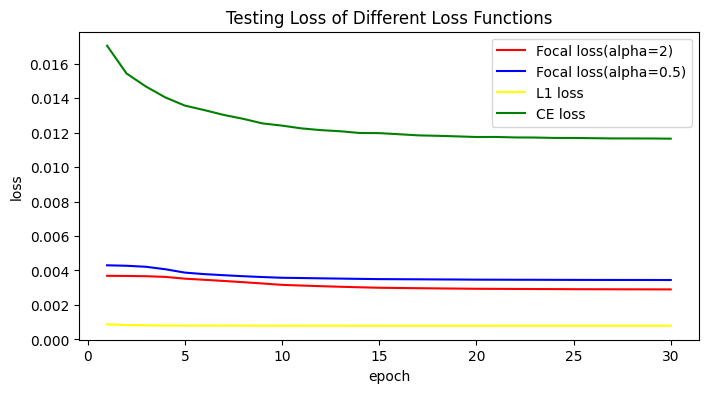

In [25]:
plt.figure(figsize=(8, 4)) 
plt.plot(numbers_range,  # 横坐标
            testing_loss_F_2,  # 纵坐标
            c='red', linestyle='-',# 点的颜色
            label='Focal loss(alpha=2)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            F_oH_te_loss,  # 纵坐标
            c='blue', linestyle='-', # 点的颜色
            label='Focal loss(alpha=0.5)')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            L1_te_loss,  # 纵坐标
            c='yellow', linestyle='-', # 点的颜色
            label='L1 loss')  # 标签 即为点代表的意思
plt.plot(numbers_range,  # 横坐标
            CE_te_loss,  # 纵坐标
            c='green', linestyle='-', # 点的颜色
            label='CE loss')  # 标签 即为点代表的意思
plt.title('Testing Loss of Different Loss Functions')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()  # 显示图例
plt.show()

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [ ]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [ ]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################

probabilities = 
predict_label = 

In [ ]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')